# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [5]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



C:\Users\longj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [6]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv" 
filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)


File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

Zillow, a leading online real estate marketplace in the United States, offers a range of services to homeowners and prospective buyers throughout the home buying and selling process. In this project, Zillow aims to develop a machine learning model that can predict property taxes for a given house using available upfront factors. Typically, property taxes are determined by local city or town authorities based on multiple variables, and they often represent a significant portion of a household’s expenses. Having an accurate estimate of these taxes in advance can help property owners better plan their finances


**1.2:**  How will your solution be used?




In our solution, we aim to predict the property tax value (the target variable, taxvaluedollarcnt) using a machine learning model trained on the available data for each house.

**1.3:**  How should success (or failure) be measured?

The predicted tax values generated by our machine learning model can be compared to the actual property tax amounts determined by the city or town in the following year. If our model’s predictions closely align with the actual tax values for individual properties, the project can be considered successful. Conversely, significant deviations between predicted and actual values would indicate a failure. In short, the smaller the gap between our model's predictions and the real property tax amounts, the more successful the project.


## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [7]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?


1 - hashottuborspa

2 - propertycountylandusecode 

3 - propertyzoningdesc   

4 - fireplaceflag

5 - taxdelinquencyflag 


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

The following 5 groups of featues have less impact to the business problem of the project due to given reasons below. 

01 -  Pool , Garage information, Outdoor Amenities with huge number of null value do not add significant value to the project to predict proposed taxt for the  
•	poolcnt (61,439 nulls)
•	pooltypeid7 (62,534 nulls)
•	pooltypeid2 (76,539 nulls)
•	pooltypeid10 (77,148 nulls)
•	poolsizesum (76,744 nulls)
•	garagecarcnt (52,093 nulls)
•	garagetotalsqft (52,093 nulls)

02 -  Following Alternative Square Footage Measures has huge null value as well as it will be an larternative to feature calculatedfinishedsquarefeet , which has less null values. 
•	finishedfloor1squarefeet (71,576 nulls)
•	finishedsquarefeet50 (71,576 nulls)
•	finishedsquarefeet15 (74,586 nulls)
•	finishedsquarefeet6 (77,227 nulls)
•	finishedsquarefeet13 (77,571 nulls)

03 -  Yard Building Measurements have huge null values and less impact on Tax calculation. 
•	yardbuildingsqft17 (75,220 nulls)
•	yardbuildingsqft26 (77,543 nulls)

04  Tax Delinquency Indicators with high null values has less impact for calculating tax information 
•	taxdelinquencyyear (74,713 nulls)
•	taxdelinquencyflag (74,713 nulls)

04 - Construction, Architectural, and Structural Details with high null values 
•	typeconstructiontypeid (77,390 nulls)
•	architecturalstyletypeid (77,406 nulls)
•	storytypeid (77,563 nulls)
•	basementsqft (77,563 nulls)
•	buildingclasstypeid (77,598 nulls)

06 -  Additional Property Attributes with High Nulls:
•	propertyzoningdesc (27,137 nulls)
•	buildingqualitytypeid (27,804 nulls)
•	heatingorsystemtypeid (28,042 nulls)
•	regionidneighborhood (46,639 nulls)
•	hashottuborspa (76,074 nulls)


**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

In [9]:
null_percentage = ((df.isnull().sum() / len(df)) * 100).astype(int)
null_percentage = null_percentage.sort_values()
print("Feaure Name & null value  %    \n" ,null_percentage)

Feaure Name & null value  %    
 parcelid                         0
bathroomcnt                      0
bedroomcnt                       0
calculatedbathnbr                0
calculatedfinishedsquarefeet     0
longitude                        0
fullbathcnt                      0
fips                             0
latitude                         0
yearbuilt                        0
roomcnt                          0
regionidzip                      0
regionidcounty                   0
rawcensustractandblock           0
propertylandusetypeid            0
propertycountylandusecode        0
assessmentyear                   0
censustractandblock              0
taxvaluedollarcnt                0
regionidcity                     1
finishedsquarefeet12             4
lotsizesquarefeet               10
unitcnt                         34
propertyzoningdesc              34
buildingqualitytypeid           35
heatingorsystemtypeid           36
regionidneighborhood            60
garagetotalsqft       

### Our Answer :  In the above cell any feature has more than 30% of null value , We assumed that it does not have a singnificant impact to the final outcome of the project 

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

1. Yes, the "assessmentyear" (Tax assement year) for this data set is 2016 and it is common for each row of data. So we can drop it.  

2.  The " Parcelid "is a unique value but it does not have any significant value or impact to the final tax value prediction excercise 

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

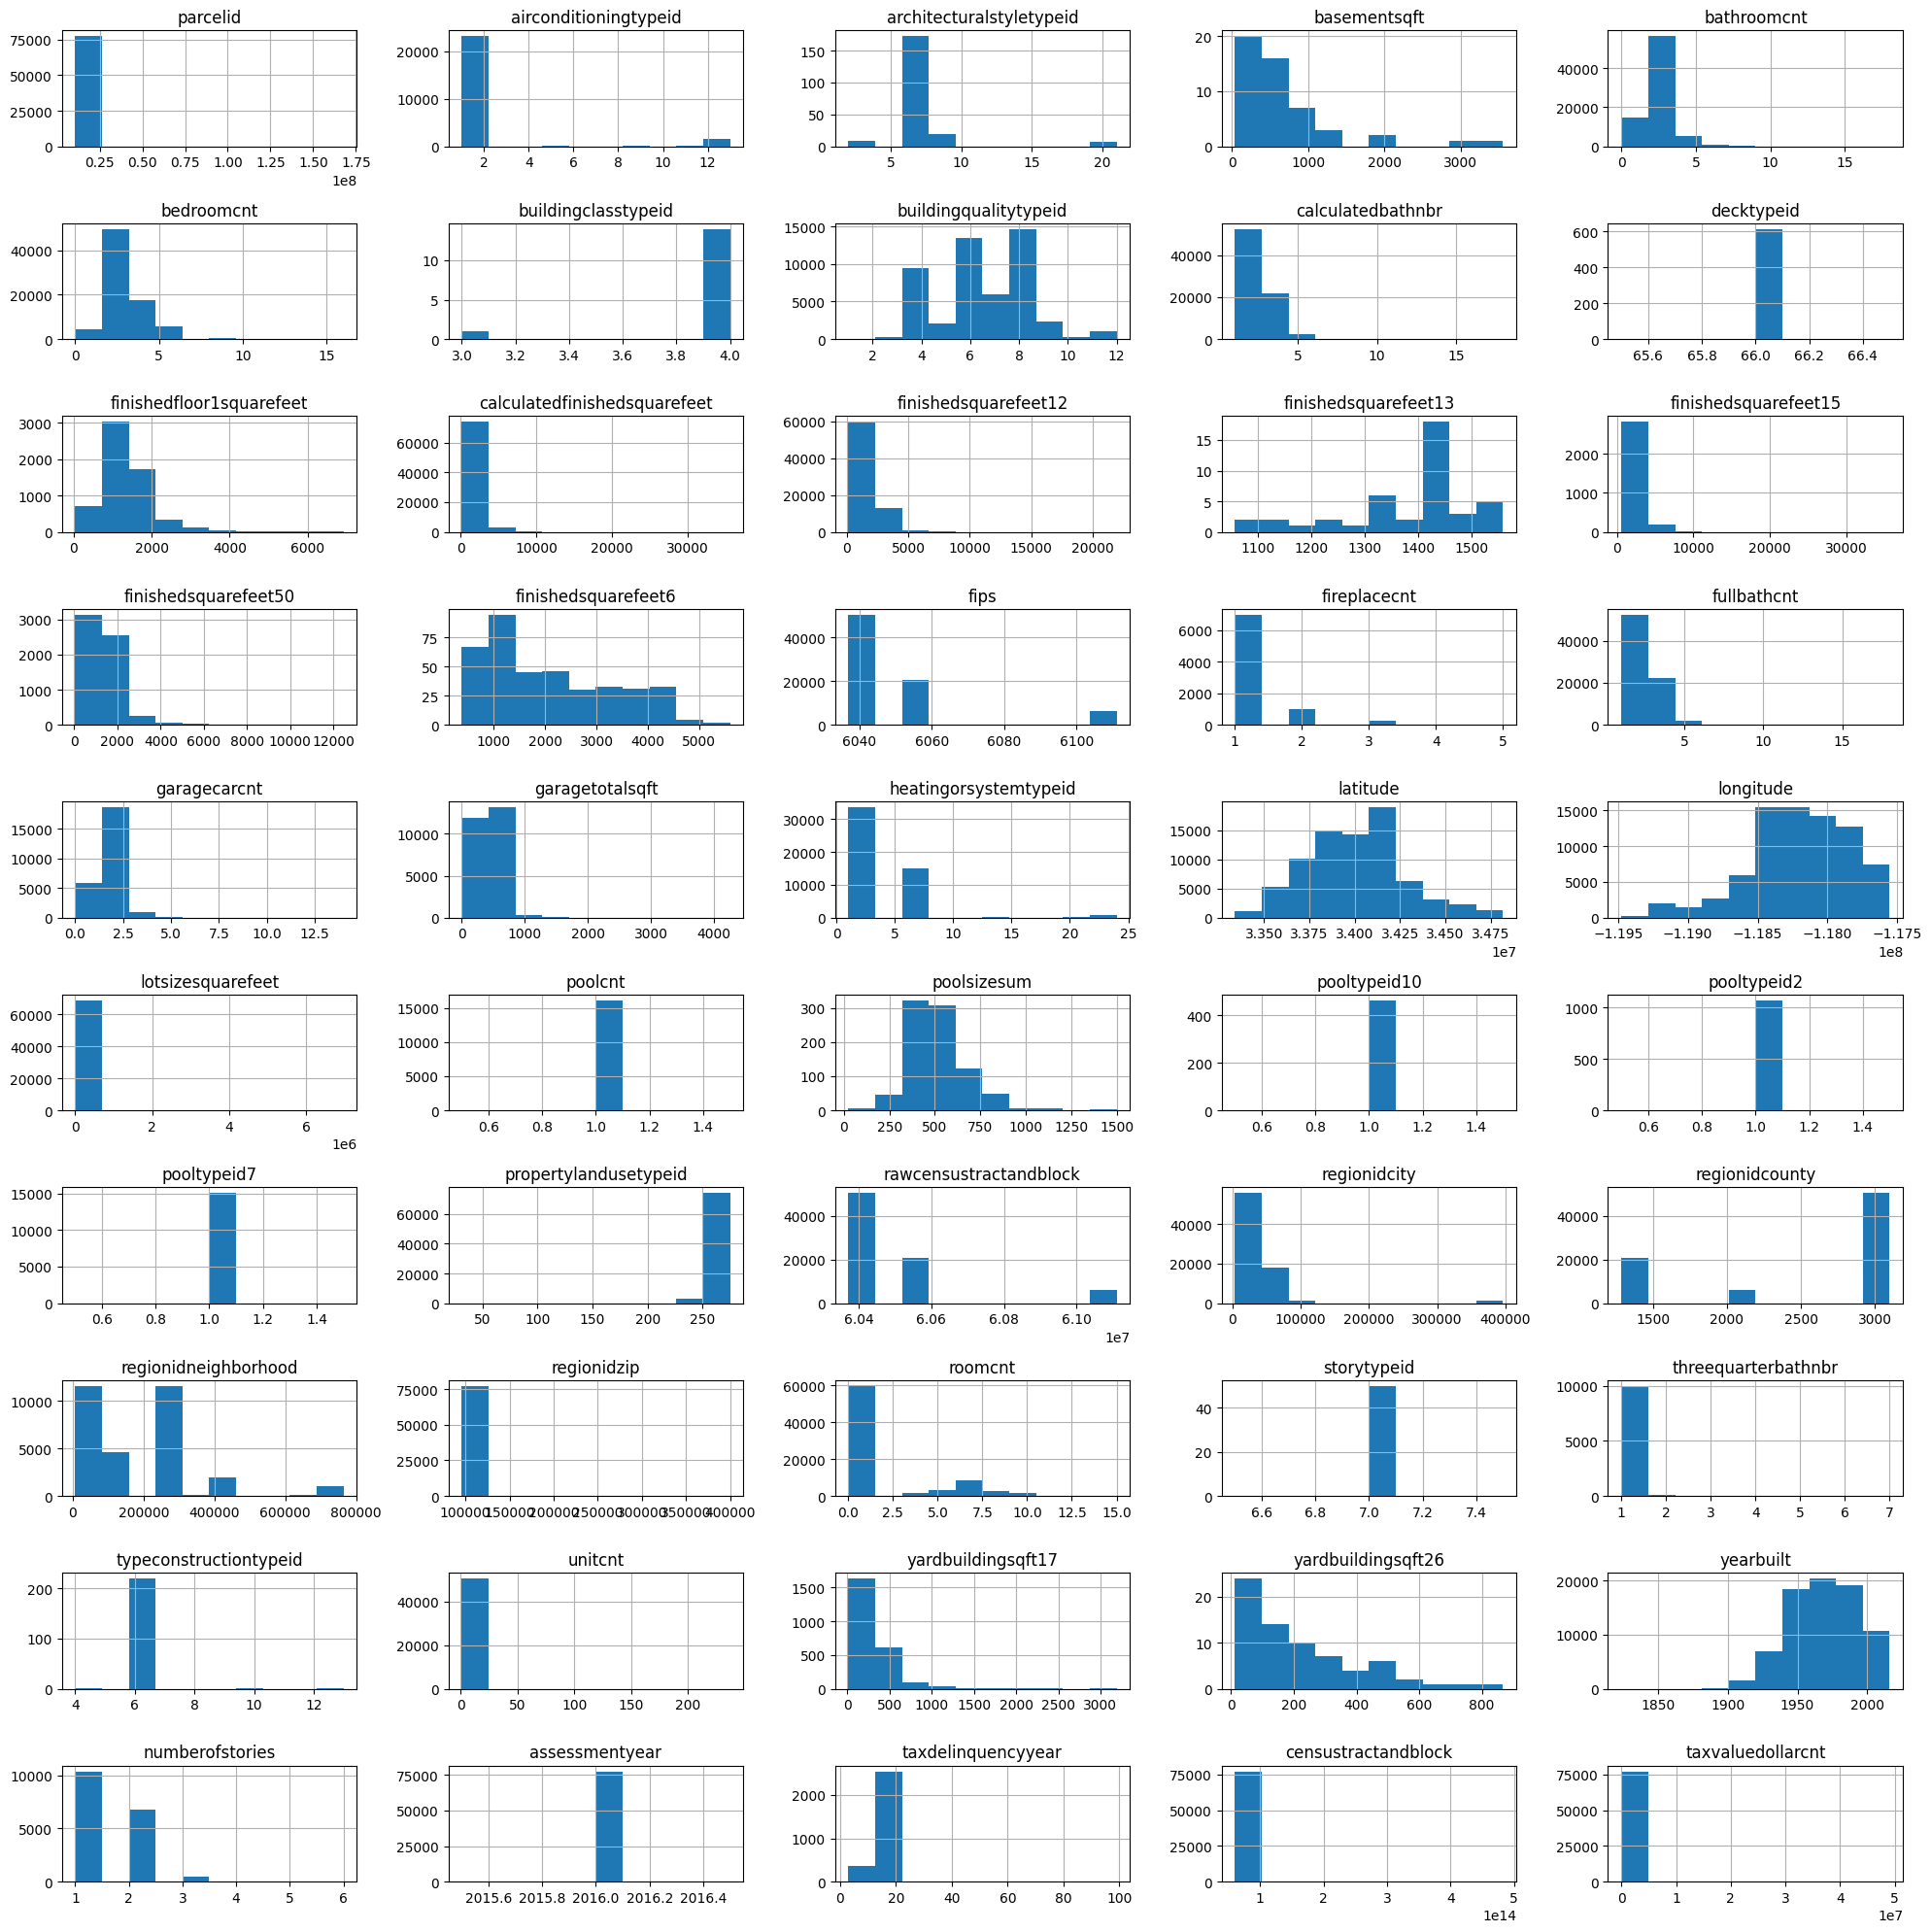

In [10]:
import matplotlib.pyplot as plt

# Set the desired number of columns in the histogram grid
m = 5

# Create histograms for all features with a large figure size and a layout with 5 columns
df.hist(figsize=(20, 20), layout=(-1, m))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

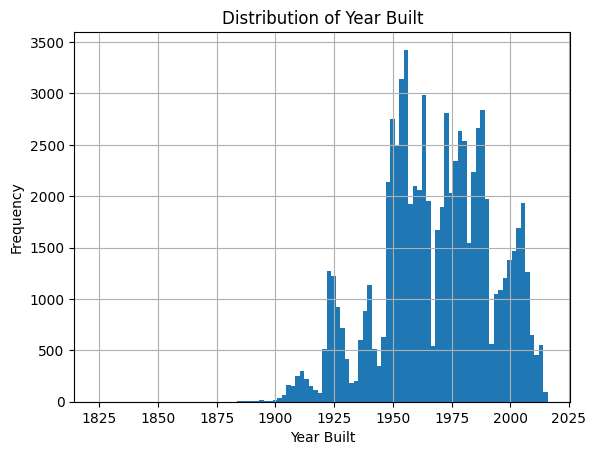

In [11]:
import matplotlib.pyplot as plt

df['yearbuilt'].hist(bins=100)
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.title('Distribution of Year Built')
plt.show()
                     

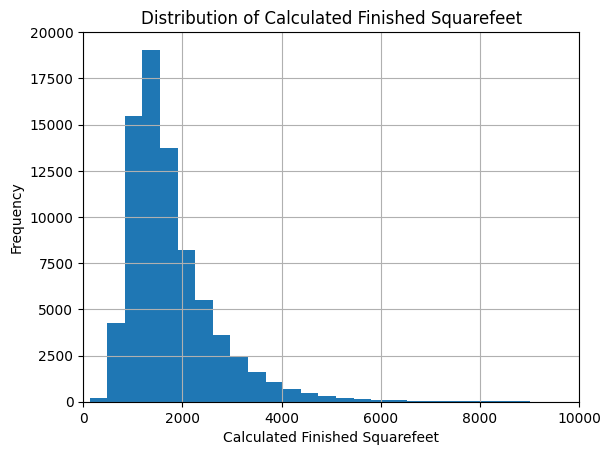

In [12]:
import matplotlib.pyplot as plt

df['calculatedfinishedsquarefeet'].hist(bins=100)
plt.xlim(0, 10000)  # Correctly setting x-axis limits from 0 to 10,000
plt.xlabel('Calculated Finished Squarefeet')
plt.ylabel('Frequency')
plt.title('Distribution of Calculated Finished Squarefeet')
plt.show()


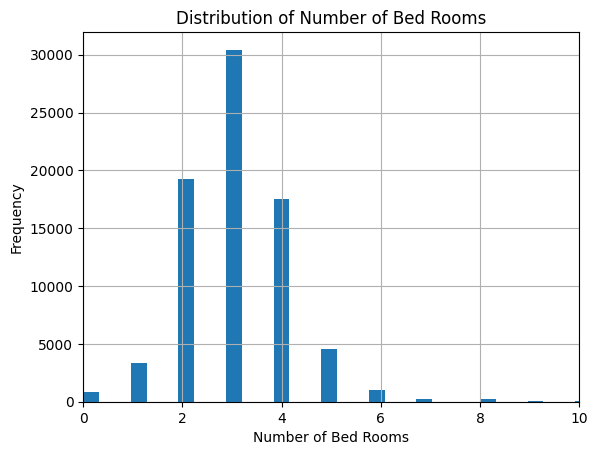

In [13]:
import matplotlib.pyplot as plt

df['bedroomcnt'].hist(bins=50)
plt.xlim(0, 10)  # Correctly setting x-axis limits from 0 to 10,000
plt.xlabel('Number of Bed Rooms')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Bed Rooms')
plt.show()

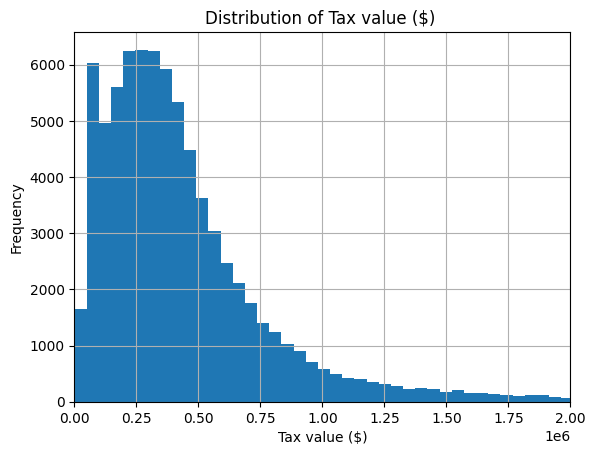

In [14]:
import matplotlib.pyplot as plt

df['taxvaluedollarcnt'].hist(bins=1000)
plt.xlim(0, 2000000)  # Correctly setting x-axis limits from 0 to 10,000
plt.xlabel('Tax value ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Tax value ($) ')
plt.show()


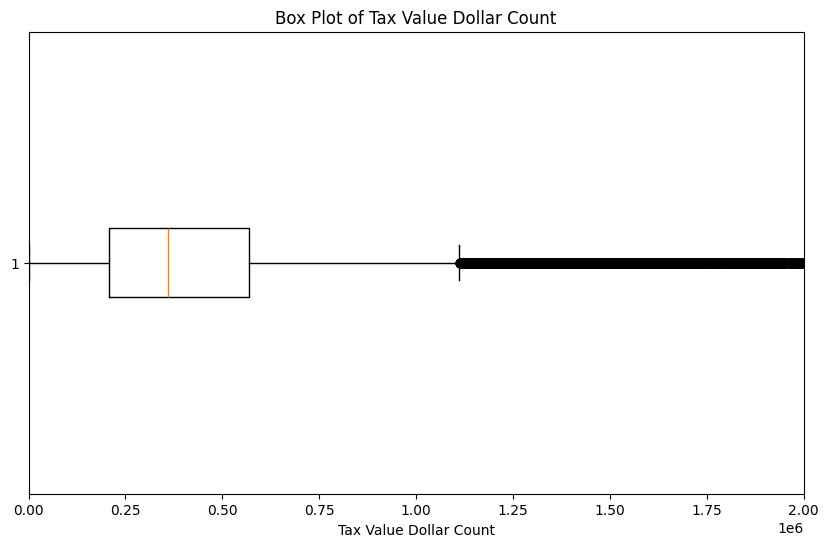

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Create a horizontal box plot; drop missing values to avoid errors.
plt.boxplot(df['taxvaluedollarcnt'].dropna(), vert=False)
plt.xlim(0, 2000000)  # Set the x-axis limits to 0 and 2,000,000
plt.xlabel('Tax Value Dollar Count')
plt.title('Box Plot of Tax Value Dollar Count')
plt.show()


#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?

    In this exercise we saw various types of distribution for features. Most of the features are NOT normally distributed. We noticed that “Built Year of House” and number of bedrooms of a house are closer to a normal distribution. Most of the other “area” related features having squid distribution. 


    Tax value graph looks somewhat exponential, especially at a glance .  But statistically, it's more likely to follow a log-normal or gamma-like distribution.

- Any problems (e.g., outliers, any odd characteristics)?

    There are few graphs had outliers – specially there was a house with 35,000 sqf , which could be a mansion or commercial building. 

    Additionally, we noticed that there were about less than 50 houses out of 77,000 has built much earlier (old) than the reset of the houses , which started around 1875 to 2015


- Anything else interesting? Why did you choose it?

Observation 1:
The histogram for Latitude shows a right-skewed distribution, while the histogram for Longitude exhibits a left-skewed pattern.

Observation 2:
We observed that area-related features (such as total square footage) are strongly correlated with the number of bedrooms, bathrooms, and other structural attributes. Furthermore, the tax dollar amount is significantly influenced by these area-related metrics.


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [16]:
# List of features to remove
cols_to_drop = [
    'propertyzoningdesc',
    'assessmentyear',
    'rawcensustractandblock',
    'censustractandblock',
    'airconditioningtypeid',
    'parcelid',
    'architecturalstyletypeid',
    'buildingclasstypeid',
    'buildingqualitytypeid',
    'calculatedbathnbr',
    'decktypeid',
    'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
    'storytypeid',
    'typeconstructiontypeid',
    'unitcnt',
    'fips',
    'propertylandusetypeid',
    'regionidcity',
    'finishedsquarefeet12',  # Removed this feature even though it is not a categorical field , becase it is a duplicate feature of calculatedfinishedsquarefeet. 
    'regionidcounty',
    'regionidneighborhood',
    'regionidzip'
]

# Remove the specified columns from df in place
df_regression = df.drop(columns=cols_to_drop)


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 


### Our Answer 

We removed features that are unsuitable for regression analysis, such as categorical IDs and category labels. While these features may be useful in classification tasks, their numerical encodings do not accurately represent the inherent magnitude or scale of the data. Consequently, excluding them from our regression model training does not compromise model performance.


We removed following  features not applicable for regression: 


•	propertyzoningdesc

•	rawcensustractandblock

•	censustractandblock

•	airconditioningtypeid

•	parcelid

•	architecturalstyletypeid

•	buildingclasstypeid

•	buildingqualitytypeid

•	calculatedbathnbr

•	decktypeid

•	pooltypeid10, pooltypeid2, pooltypeid7

•	storytypeid

•	typeconstructiontypeid

•	unitcnt

o	fips

o	regionidcity

o	regionidcounty

o	regionidneighborhood

o	regionidzip




### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [18]:
# let's calculate the null value % and we can remove any features has more than 30% of null values in. 

# Calculate the percentage of null values per column
null_percentage = ((df_regression.isnull().sum() / len(df_regression)) * 100).astype(int)
null_percentage = null_percentage.sort_values()

# Identify the columns with 30% or fewer null values
cols_to_keep = null_percentage[null_percentage <= 30].index.tolist()

# Alternatively, identify the columns to drop (those with more than 30% null values)
# cols_to_drop = null_percentage[null_percentage > 30].index.tolist()

# Create a new DataFrame that only includes the columns with acceptable null values
df_clean = df_regression[cols_to_keep]

# Optionally, verify by printing the cleaned DataFrame's columns
df_clean.columns

df_clean

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,latitude,roomcnt,propertycountylandusecode,longitude,yearbuilt,taxvaluedollarcnt,lotsizesquarefeet
0,3.5,4.0,3100.0,3.0,33634931.0,0.0,122,-117869207.0,1998.0,1023282.0,4506.0
1,1.0,2.0,1465.0,1.0,34449266.0,5.0,1110,-119281531.0,1967.0,464000.0,12647.0
2,2.0,3.0,1243.0,2.0,33886168.0,6.0,122,-117823170.0,1962.0,564778.0,8432.0
3,3.0,4.0,2376.0,3.0,34245180.0,0.0,0101,-118240722.0,1970.0,145143.0,13038.0
4,3.0,3.0,1312.0,3.0,34185120.0,0.0,010C,-118414640.0,1964.0,119407.0,278581.0
...,...,...,...,...,...,...,...,...,...,...,...
77608,3.0,3.0,1741.0,3.0,34202400.0,0.0,010C,-118502000.0,1980.0,379000.0,59487.0
77609,2.0,2.0,1286.0,2.0,34245368.0,0.0,0100,-118282383.0,1940.0,354621.0,47405.0
77610,2.0,4.0,1612.0,2.0,34300140.0,7.0,1111,-118706327.0,1964.0,67205.0,12105.0
77611,1.0,3.0,1032.0,1.0,34040895.0,0.0,0100,-118038169.0,1954.0,49546.0,5074.0


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



###  Our Answer : 

We chose to drop features with more than 30% missing values, even though some of them might have been potentially useful for the regression model. Before removal, we carefully assessed whether excluding these high-null features would negatively impact the business relevance and predictive power related to our target variable, property tax value.

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [19]:
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77579 non-null  float64
 1   bedroomcnt                    77579 non-null  float64
 2   calculatedfinishedsquarefeet  77378 non-null  float64
 3   fullbathcnt                   76963 non-null  float64
 4   latitude                      77579 non-null  float64
 5   roomcnt                       77579 non-null  float64
 6   propertycountylandusecode     77579 non-null  object 
 7   longitude                     77579 non-null  float64
 8   yearbuilt                     77309 non-null  float64
 9   taxvaluedollarcnt             77578 non-null  float64
 10  lotsizesquarefeet             69321 non-null  float64
dtypes: float64(10), object(1)
memory usage: 6.5+ MB


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


#### Our Answer 

We removed features that were unsuitable for regression analysis, including categorical identifiers and descriptive category labels. Additionally, we dropped features with over 30% missing values, despite the possibility that some could have contributed to model performance. Prior to removal, we evaluated whether excluding these high-null features would affect the business relevance and predictive accuracy of our target variable—property tax value.

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [20]:
# let's calculate the % of samples in in each colum null values 

null_percentage = ((df_clean.isnull().sum() / len(df_clean)) * 100)
null_percentage = null_percentage.sort_values()
print("Feaure & null value %\n" ,null_percentage)

Feaure & null value %
 bathroomcnt                      0.043807
bedroomcnt                       0.043807
roomcnt                          0.043807
latitude                         0.043807
propertycountylandusecode        0.043807
longitude                        0.043807
taxvaluedollarcnt                0.045096
calculatedfinishedsquarefeet     0.302784
yearbuilt                        0.391687
fullbathcnt                      0.837489
lotsizesquarefeet               10.683777
dtype: float64


In [21]:
# we can drop the samples has less than  1% of null values, except the lotsizesquarefeet feature wich has 10% of null values and we should fill null values with Mean.

df_clean.dropna(subset=['latitude', 'roomcnt', 'propertycountylandusecode', 'longitude', 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'fullbathcnt'], inplace=True)

# Fill the lotsizesquarefeet with mean value of the column 

df_clean['lotsizesquarefeet'].fillna(df_clean['lotsizesquarefeet'].mean(), inplace=True)

null_percentage = ((df_clean.isnull().sum() / len(df_clean)) * 100)
null_percentage = null_percentage.sort_values()
print("Feaure & null value %\n" ,null_percentage)


Feaure & null value %
 bathroomcnt                     0.0
bedroomcnt                      0.0
calculatedfinishedsquarefeet    0.0
fullbathcnt                     0.0
latitude                        0.0
roomcnt                         0.0
propertycountylandusecode       0.0
longitude                       0.0
yearbuilt                       0.0
taxvaluedollarcnt               0.0
lotsizesquarefeet               0.0
dtype: float64


C:\Users\longj\AppData\Local\Temp\ipykernel_39456\878882747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(subset=['latitude', 'roomcnt', 'propertycountylandusecode', 'longitude', 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'fullbathcnt'], inplace=True)
C:\Users\longj\AppData\Local\Temp\ipykernel_39456\878882747.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] =

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### Answer :

In our final cleaned dataset (df_clean), all selected columns had less than 1% missing values, except for the lotsizesquarefeet column, which had approximately 10% missing data. We handled this by removing rows with missing values in columns where nulls were under 1%, and for lotsizesquarefeet, we imputed the missing values using the column's mean.


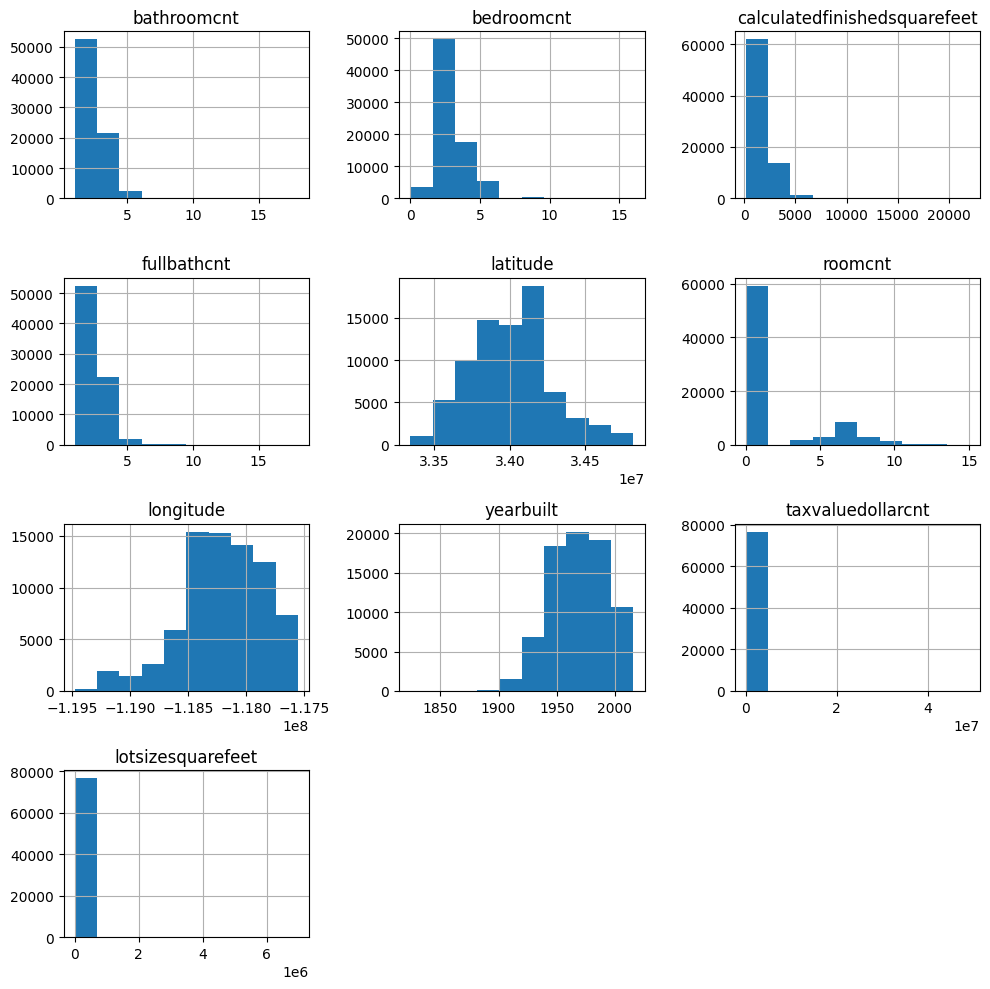

In [22]:
import matplotlib.pyplot as plt

# Set the desired number of columns in the histogram grid
m = 3

# Create histograms for all features with a large figure size and a layout with 5 columns
df_clean.hist(figsize=(10, 10), layout=(-1, m))
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

### Answer : 

We do not have categorical data that we need to Encode 

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

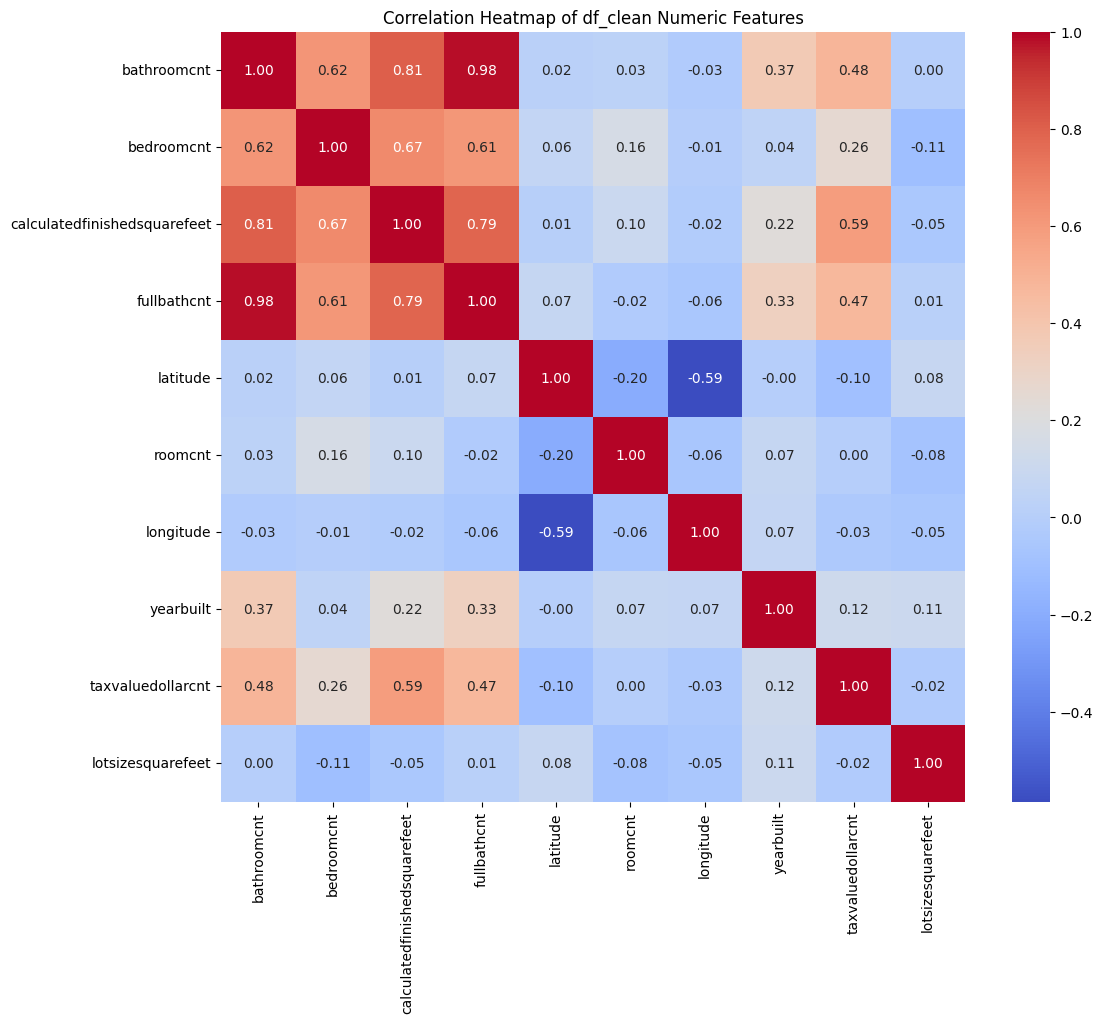

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df_clean.select_dtypes(include=['number'])

# Compute the correlation matrix on the numeric columns
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of df_clean Numeric Features")
plt.show()


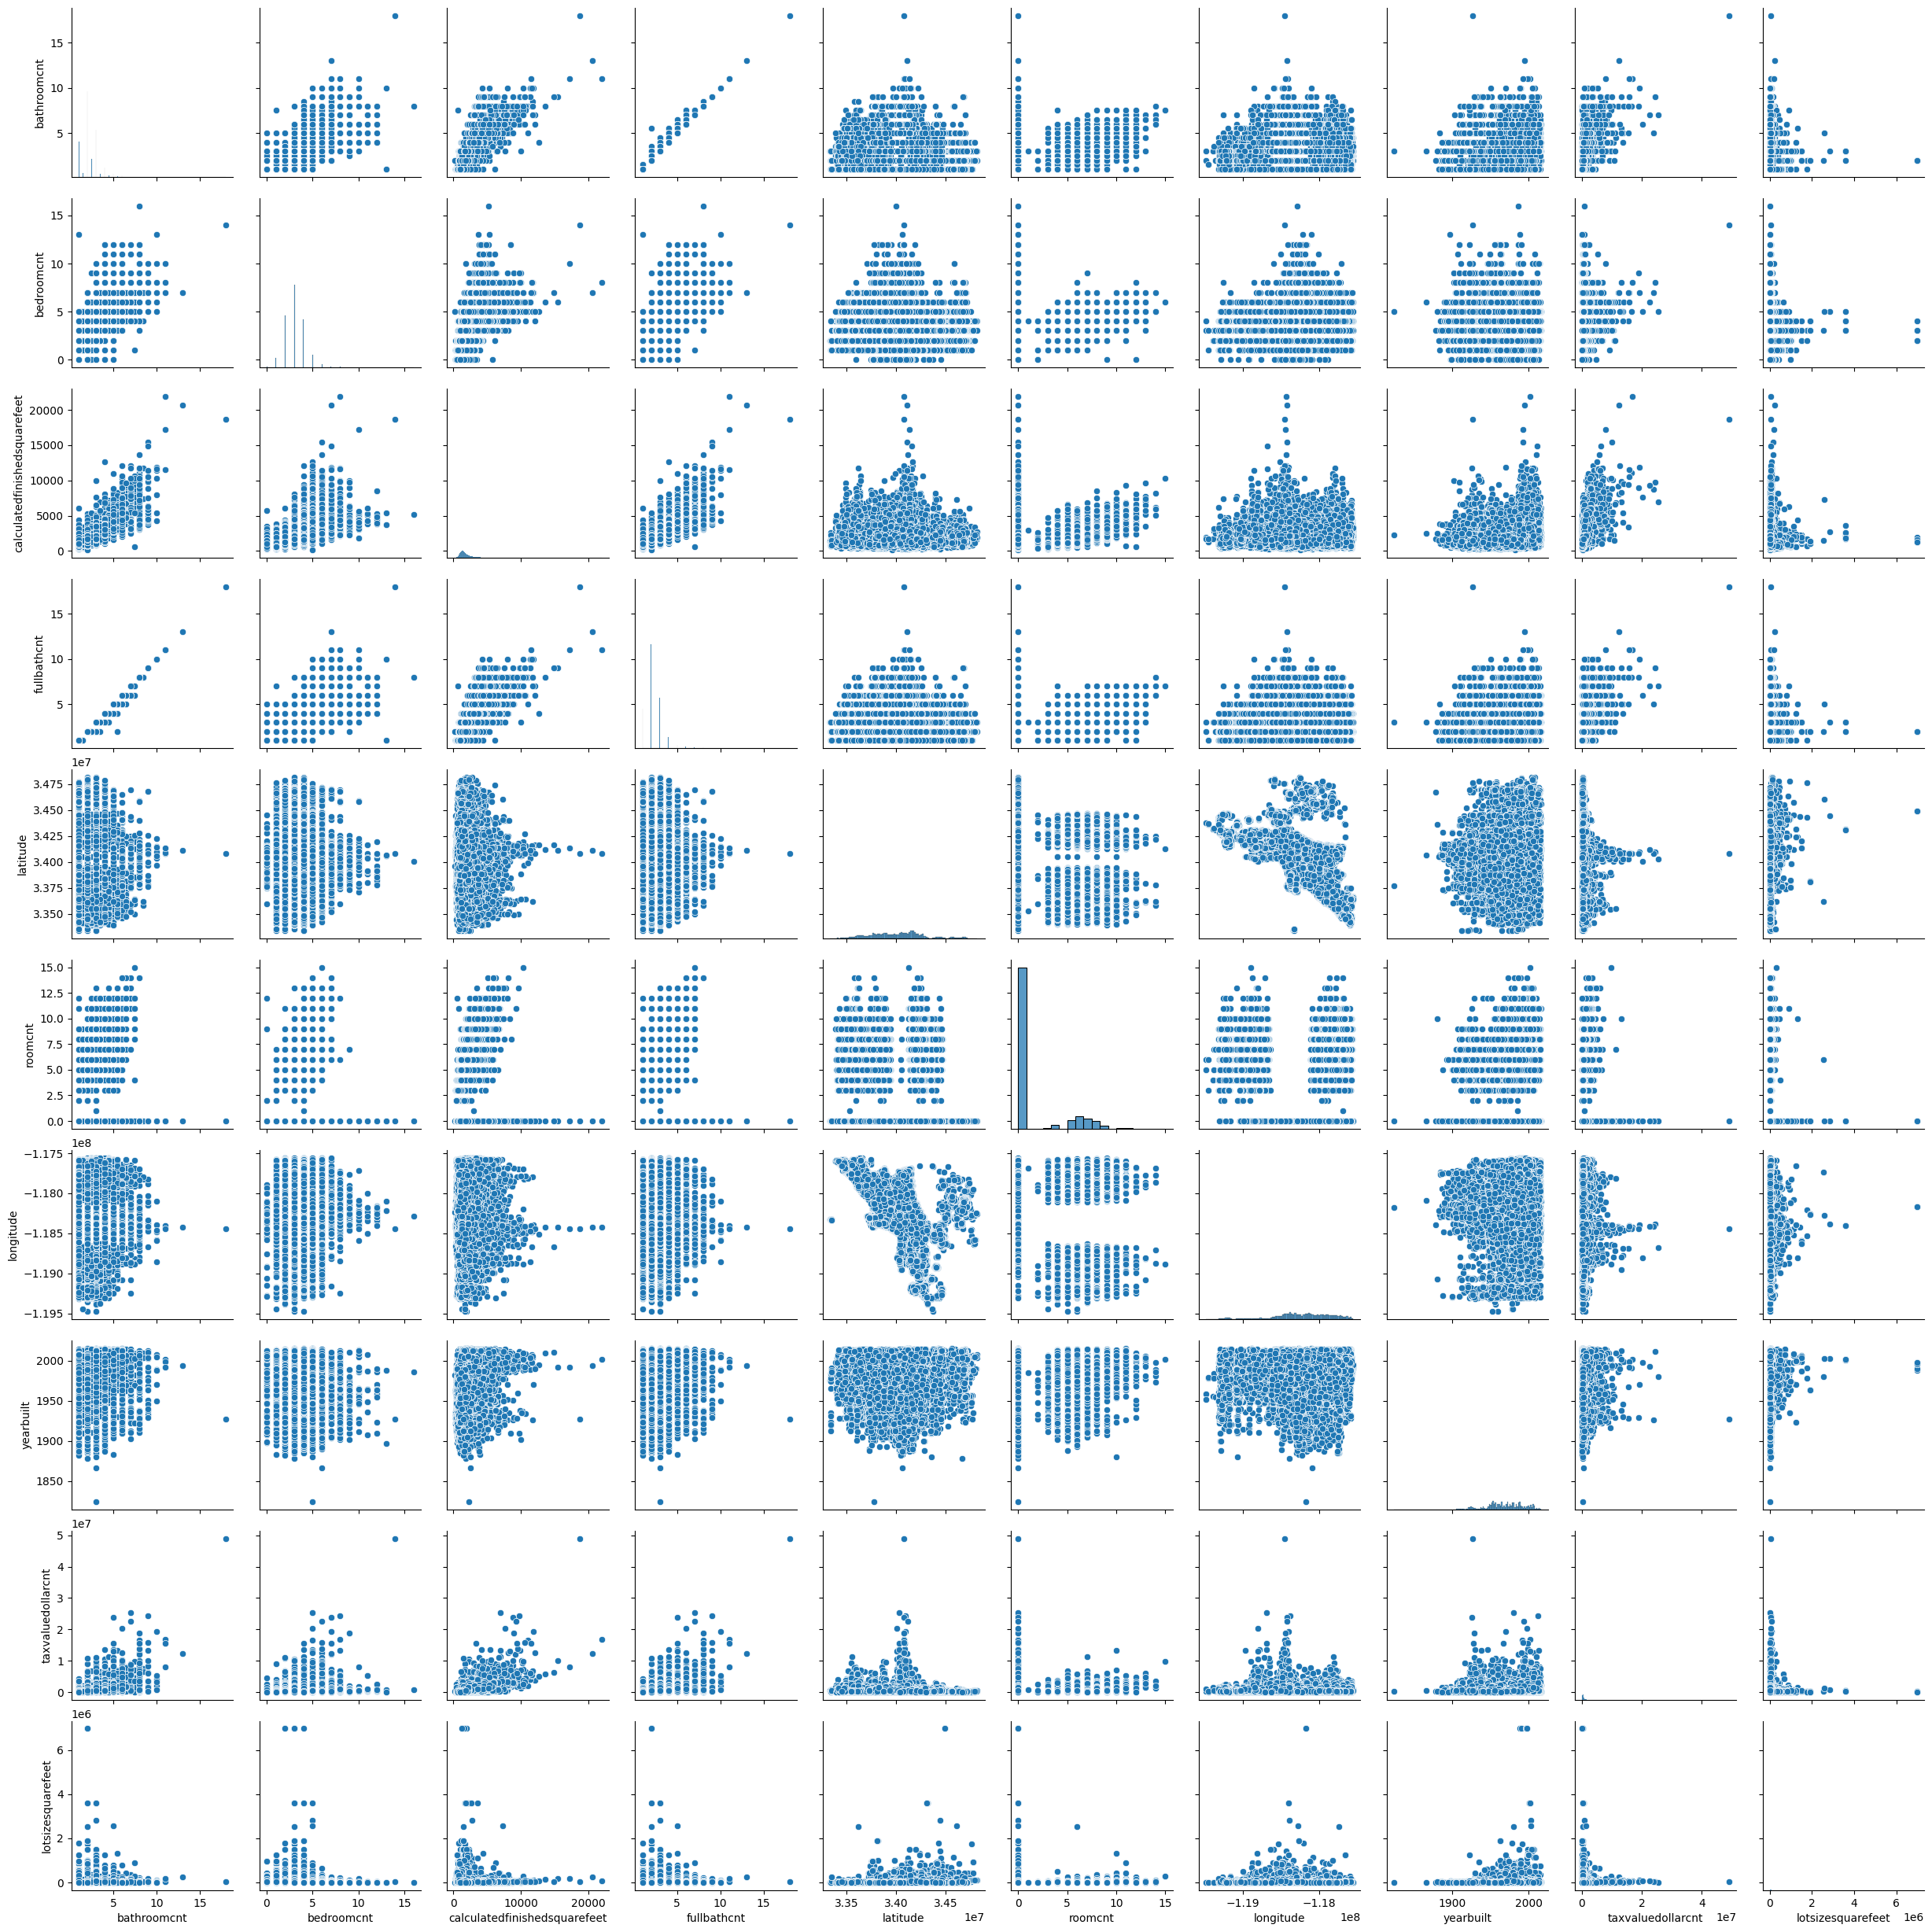

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df_clean)
plt.show()

<Axes: >

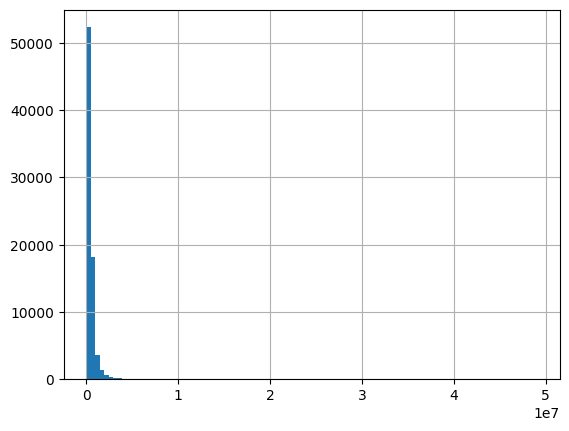

In [25]:
df_clean['taxvaluedollarcnt'].hist(bins= 100)

In [28]:
df_clean.columns.to_list()

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'latitude',
 'roomcnt',
 'propertycountylandusecode',
 'longitude',
 'yearbuilt',
 'taxvaluedollarcnt',
 'lotsizesquarefeet']

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
X = df_clean.select_dtypes(include=['float64', 'int64']).drop(columns='taxvaluedollarcnt')
y = df_clean['taxvaluedollarcnt']

In [29]:
print(X.shape[1])  # This shows how many features you have


9


In [31]:
model = LinearRegression()
# Forward selection
forward_selector = SequentialFeatureSelector(model, direction='forward', n_features_to_select=8)
forward_selector.fit(X, y)

# Show selected features
forward_selected_features = X.columns[forward_selector.get_support()]
print("Forward Selected Features:")
print(forward_selected_features.tolist())


Forward Selected Features:
['bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'roomcnt', 'longitude', 'yearbuilt', 'lotsizesquarefeet']


In [32]:
# Backward selection
backward_selector = SequentialFeatureSelector(model, direction='backward', n_features_to_select=8)
backward_selector.fit(X, y)

# Show selected features
backward_selected_features = X.columns[backward_selector.get_support()]
print("Backward Selected Features:")
print(backward_selected_features.tolist())

Backward Selected Features:
['bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'latitude', 'roomcnt', 'longitude', 'yearbuilt', 'lotsizesquarefeet']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### My Answer

The target variable, taxvaluedollarcnt, is highly correlated with the house’s area (square footage), which is indirectly linked to the number of bedrooms and bathrooms. Additionally, taxvaluedollarcnt shows a notable correlation (0.22) with the year built. Furthermore, the number of bedrooms and bathrooms are strongly correlated with each other (0.62), and both are also strongly associated with the calculated finished square footage.

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

In [ ]:
# Calculate Q1, Q3, and the IQR for taxvaluedollarcnt
Q1 = df_clean['taxvaluedollarcnt'].quantile(0.25)
Q3 = df_clean['taxvaluedollarcnt'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_clean = df_clean[(df_clean['taxvaluedollarcnt'] >= lower_bound) & (df_clean['taxvaluedollarcnt'] <= upper_bound)]


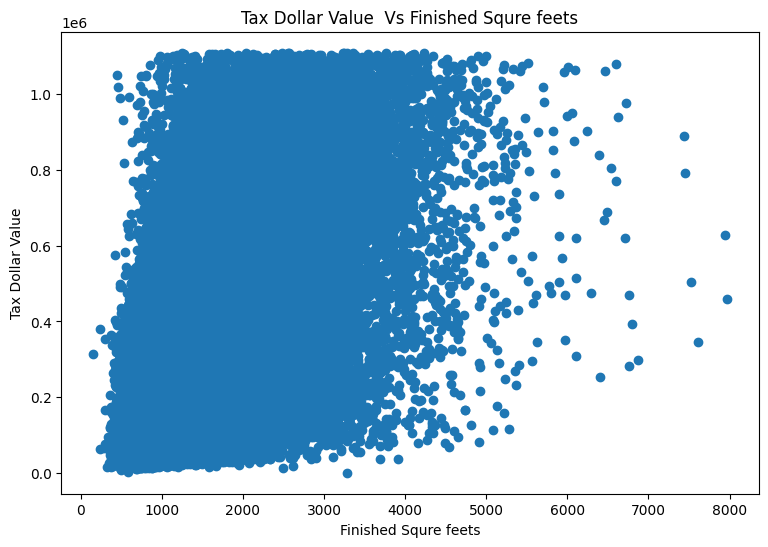

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 6))

plt.scatter(df_clean['calculatedfinishedsquarefeet'],df_clean['taxvaluedollarcnt'])
plt.xlabel('Finished Squre feets')
plt.ylabel('Tax Dollar Value')
plt.title('Tax Dollar Value  Vs Finished Squre feets')
plt.show()


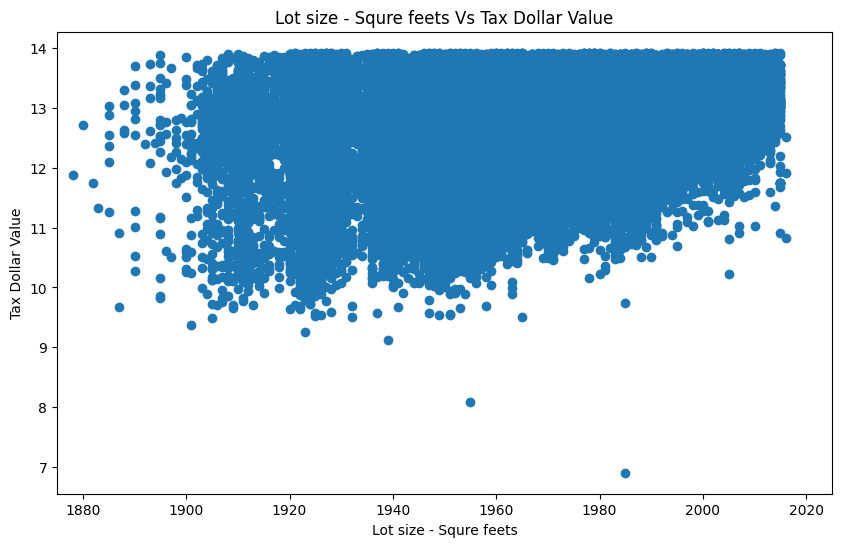

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df_clean['yearbuilt'],np.log(df_clean['taxvaluedollarcnt']))
plt.xlim (1875,2025)

plt.xlabel('Lot size - Squre feets')
plt.ylabel('Tax Dollar Value')
plt.title('Lot size - Squre feets Vs Tax Dollar Value')
plt.show()



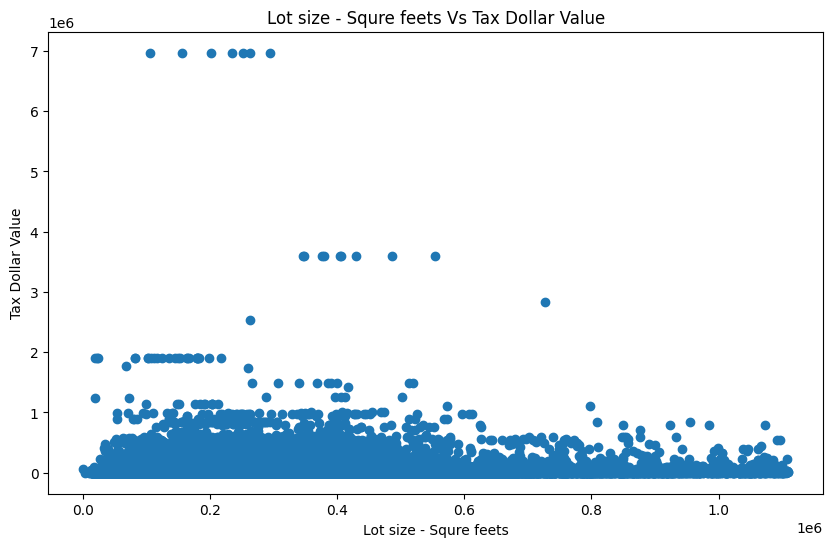

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(df_clean['taxvaluedollarcnt'],df_clean['lotsizesquarefeet'])

plt.xlabel('Lot size - Squre feets')
plt.ylabel('Tax Dollar Value')
plt.title('Lot size - Squre feets Vs Tax Dollar Value')
plt.show()


#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


#### My Answer : 

01.	There is a strong positive correlation with Tax Doller value and Completed Square feet amount of the house. 

02.	There is a positive but not strong correlation with the Tax Doller value and built year of the house. 

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

#### Tranformation Method #1 - Logrithmic 

In the following example we are trying to find the corr() between calculatedfinishedsquarefeet and log (calculatedfinishedsquarefeet) against target (taxvaluedollarcnt ). In this particular case we do not see an improvement but we can leverage this technique for other features.


In [ ]:
import numpy as np
import pandas as pd

# Create transformed feature using log1p (to avoid log(0))
df_clean['log_finished_sqft'] = np.log1p(df_clean['calculatedfinishedsquarefeet'])

# Compute correlation of both the original and log-transformed features with target
orig_corr = df_clean['calculatedfinishedsquarefeet'].corr(df_clean['taxvaluedollarcnt'])
log_corr = df_clean['log_finished_sqft'].corr(df_clean['taxvaluedollarcnt'])

print(f"Correlation (original finished sqft): {orig_corr:.3f}")
print(f"Correlation (log finished sqft): {log_corr:.3f}")



Correlation (original finished sqft): 0.476
Correlation (log finished sqft): 0.468


/var/folders/kh/kc5y0fqx3r36q4fp59dt5lpm0000gn/T/ipykernel_34027/1884299567.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['log_finished_sqft'] = np.log1p(df_clean['calculatedfinishedsquarefeet'])


### Tranformation Method #2 - polynomial features  

In the following example , we are trying to find the correlation between square of room count (roomcnt) and (Bed-room_count * bath-roomcount) and compare it against the target (taxvaluedollarcnt). Where we may find improved correlations againt the target. 

In [ ]:

# Create polynomial features
df_clean['roomcnt_squared'] = df_clean['roomcnt'] ** 2

# Create an interaction term (product)
df_clean['bed_bath_interaction'] = df_clean['bedroomcnt'] * df_clean['bathroomcnt']

# Compute correlations
room_sq_corr = df_clean['roomcnt_squared'].corr(df_clean['taxvaluedollarcnt'])
interaction_corr = df_clean['bed_bath_interaction'].corr(df_clean['taxvaluedollarcnt'])

print(f"Correlation (roomcnt squared): {room_sq_corr:.3f}")
print(f"Correlation (bedroom * bathroom): {interaction_corr:.3f}")


Correlation (roomcnt squared): 0.105
Correlation (bedroom * bathroom): 0.331


/var/folders/kh/kc5y0fqx3r36q4fp59dt5lpm0000gn/T/ipykernel_34027/3901056910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['roomcnt_squared'] = df_clean['roomcnt'] ** 2
/var/folders/kh/kc5y0fqx3r36q4fp59dt5lpm0000gn/T/ipykernel_34027/3901056910.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['bed_bath_interaction'] = df_clean['bedroomcnt'] * df_clean['bathroomcnt']


### Tranfomation Method #3 - Feature Scaling (Standardization)

In [ ]:
from sklearn.preprocessing import StandardScaler

# List of features to standardize (as an example)
features_to_scale = ['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'yearbuilt']
scaler = StandardScaler()

# Fit and transform the selected features
df_clean_scaled = df_clean.copy()
df_clean_scaled[features_to_scale] = scaler.fit_transform(df_clean[features_to_scale])

# Display summary statistics of the scaled features
print(df_clean_scaled[features_to_scale].describe())


       calculatedfinishedsquarefeet  lotsizesquarefeet     yearbuilt
count                  7.178800e+04       7.178800e+04  7.178800e+04
mean                  -8.526948e-17      -1.964712e-17  5.661537e-17
std                    1.000007e+00       1.000007e+00  1.000007e+00
min                   -2.096239e+00      -2.539064e-01 -6.170120e+00
25%                   -6.937001e-01      -2.064709e-01 -6.526840e-01
50%                   -2.285085e-01      -1.931020e-01  3.164914e-02
75%                    4.511727e-01      -7.190937e-02  7.587531e-01
max                    8.792588e+00       5.806391e+01  2.041878e+00


### Tranformation Method #4 :  Univariate Feature Selection (F-score using SelectKBest)



In [ ]:
# Method : Univariate Feature Selection (F-score using SelectKBest)

# Keep only numeric columns
df_numeric = df_clean.select_dtypes(include=['number'])

# Drop rows with missing values for simplicity
df_numeric = df_numeric.dropna()

# Define features and target
X = df_numeric.drop(columns=['taxvaluedollarcnt'])
y = df_numeric['taxvaluedollarcnt']

from sklearn.feature_selection import SelectKBest, f_regression

# Select top 10 features based on F-score
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
scores = selector.scores_

# Display feature names with F-scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'F_score': scores})
print(feature_scores.sort_values(by='F_score', ascending=False).head(10))

                         Feature       F_score
7   calculatedfinishedsquarefeet  20998.247561
9              log_finished_sqft  20120.259946
5                    bathroomcnt  14043.876985
4                    fullbathcnt  11845.565686
11          bed_bath_interaction   8813.095797
6                     bedroomcnt   4185.627956
1                      yearbuilt   3723.169995
0                       latitude   1702.834452
10               roomcnt_squared    806.427011
2                        roomcnt    362.373815


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


### Our Answer : 
In the Zillow dataset, the native distributions (i.e., raw feature distributions) exhibit a variety of shapes, often making it difficult to identify clear patterns or directional relationships. However, after applying data transformation techniques such as logarithmic scaling, polynomial features, feature scaling, and univariate feature selection (using F-scores with SelectKBest), we were able to uncover different covariances between features. While in some cases these transformed features showed less importance than the original ones, the exercise highlighted the value of transformation techniques in enhancing feature relationships—particularly when applied thoughtfully and aligned with the chosen model.

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

